In [169]:
import os
import opsimsummary as oss
import healpy as hp
from opsimsummary import SynOpSim
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
import pickle
import astropy
from astropy.coordinates import SkyCoord
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
plt.rc("font", family="serif")
plt.rc("text", usetex=True)

## Notes

First 3 years of survey: t_start = 60220, t_end = 61325 (from Catarina) <br>
There is no column with (ra, dec) of the source, so save this as the mean of fieldRA and fieldDec. <br>
<br>
Year 0  -  03/10/2023  -  MJD 60220 <br>
Year 1  -  03/10/2024  -  MJD 60586 <br>
Year 2  -  03/10/2025  -  MJD 60951 <br>
Year 3  -  03/10/2026  -  MJD 61316 <br>
Year 4  -  03/10/2027  -  MJD 61681 <br>
Year 5  -  03/10/2028  -  MJD 62047 <br>
Year 6  -  03/10/2029  -  MJD 62412 <br>
Year 7  -  03/10/2030  -  MJD 62777 <br>
Year 8  -  03/10/2031  -  MJD 63142 <br>
Year 9  -  03/10/2032  -  MJD 63508 <br>
Year 10 -  03/10/2033  -  MJD 63873 <br>

## LSST zero points

In [2]:
LSST_g = {'magnitude_zero_point': 28.30,
          'average_seeing': 0.77,
          'sky_brightness': 22.26,
          'limiting_magnitude': 25.0}

LSST_r = {'magnitude_zero_point': 28.13,
          'average_seeing': 0.73,
          'sky_brightness': 21.2,
          'limiting_magnitude': 24.7}

LSST_i = {'magnitude_zero_point': 27.79,
          'average_seeing': 0.71,
          'sky_brightness': 20.48,
          'limiting_magnitude': 24.0}

LSST_z = {'magnitude_zero_point': 27.40,
          'average_seeing': 0.69,
          'sky_brightness': 19.6,
          'limiting_magnitude': 23.3}

LSST_y = {'magnitude_zero_point': 26.58,
          'average_seeing': 0.68,
          'sky_brightness': 18.61,
          'limiting_magnitude': 22.1}

def zeropoint(band):
    if band == 'g':
        obs_dict = LSST_g
    elif band == 'r':
        obs_dict = LSST_r
    elif band == 'i':
        obs_dict = LSST_i
    elif band == 'z':
        obs_dict = LSST_z
    elif band == 'y':
        obs_dict = LSST_y
    else:
        raise ValueError("band %s not supported! Choose 'g', 'r', 'i', 'z' or 'y' for LSST." % band)

    return obs_dict['magnitude_zero_point']


def flux(mag, zero_point):
    return 10**((zero_point - mag)/2.5)

def radians(degrees):
    return degrees / 180 * np.pi

## Sky Pointings

Sample points with -90 < DEC < 40

deg
[ 17.73182155  16.49176845 -18.71392818 ...  55.26903265   2.21973029
  46.07375747]


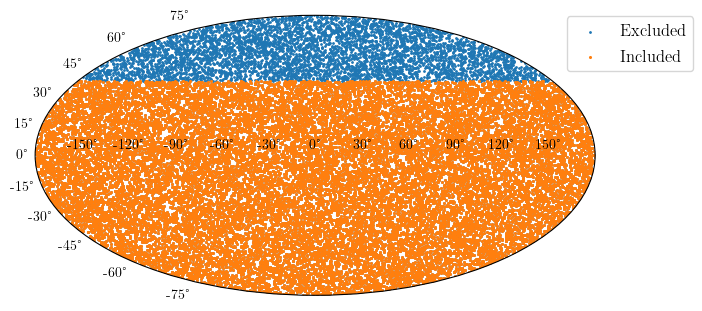

In [16]:
# ra = coord.Angle(meta['RA']*u.degree)
# ra = ra.wrap_at(180*u.degree)
# dec = coord.Angle(meta['DEC']*u.degree)

print(u.degree)


# Input coordinates

N = 30000

# Sample random points on a sphere
# ra_points = np.random.uniform(low=-180, high=180, size=N)
# dec_points = np.arcsin(2 * np.random.uniform(size=N) - 1) / np.pi * 180

ra_points = coord.Angle(np.random.uniform(low=0, high=360, size=N) * u.degree)
ra_points = ra_points.wrap_at(180*u.degree)
dec_points = np.arcsin(2 * np.random.uniform(size=N) - 1) / np.pi * 180
dec_points = coord.Angle(dec_points * u.degree)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(ra_points.radian, dec_points.radian, s=1, label="Excluded")

print(dec_points.degree)

dec_selection = (dec_points.degree > -90) & (dec_points.degree < 40)
ra_points = ra_points[dec_selection]
dec_points = dec_points[dec_selection]
im1 = ax1.scatter(ra_points.radian, dec_points.radian, s=1.5, label="Included")
plt.legend(loc=(0.95, 0.8), fontsize=12)

# ra_points += 180

## OpSim Summary

In [21]:
myopsimv3 = '../data/OpSim_databases/baseline_v3.0_10yrs.db'

In [22]:
synopsim = SynOpSim.fromOpSimDB(myopsimv3, opsimversion='fbsv2', usePointingTree=True, use_proposal_table=False,
                               subset='unique_all')

 reading from database sqlite:///../data/OpSim_databases/baseline_v3.0_10yrs.db
We have filterNull set to False
checking that summary table read in

Reading in raw tables successful
replacing names works
dropping duplicates works
dithered column names exists 
Changing units for fbsv2 from degrees


In [23]:
gen = synopsim.pointingsEnclosing(ra_points.degree, dec_points.degree, circRadius=0., pointingRadius=1.75, 
                                  usePointingTree=True)


In [8]:
dates = next(gen)

check using ptree True


In [63]:
print(min(dates['expMJD']), max(dates['expMJD']))

60220.09329523946 63857.09894690529


In [24]:
# Loop through all pointings and save the ones that are in the LSST footprint

opsim_ra_list, opsim_dec_list = [], []

for p in range(len(ra_points)):
    
    obs = next(gen)
    
    opsim_ra = np.mean(obs['fieldRA'])
    opsim_dec = np.mean(obs['fieldDec'])

    if np.isnan(opsim_ra) or np.isnan(opsim_dec):
        continue
    
    opsim_ra_list.append(opsim_ra)
    opsim_dec_list.append(opsim_dec)
    
opsim_ra_list = np.array(opsim_ra_list)
opsim_dec_list = np.array(opsim_dec_list)

check using ptree True


In [25]:
# opsim_ra_list -= 180
opsim_ra1 = coord.Angle(opsim_ra_list * u.degree)
opsim_dec = coord.Angle(opsim_dec_list * u.degree)

opsim_ra2 = - opsim_ra1.wrap_at(180*u.degree)

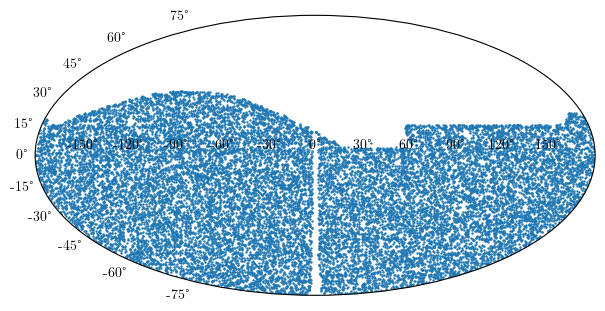

In [26]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(opsim_ra2.radian, opsim_dec.radian, s=0.5)

In [229]:
print(len(opsim_dec_list))

20335


In [231]:
print(20335 / 30000)
print(1/0.677833333)

0.6778333333333333
1.4752889114705132


## Cadence analysis

In [28]:
def is_active(ra, dec):
    return (((dec > -16) & 
            ((ra < 95) | (ra > 260))) | (((dec > -49) & (dec <= -31)) & ((ra <= 120) | (ra > 245))) |
             (((dec > -25) & (dec <= -8)) & (ra >= 110) & (ra <= 245)) | (dec > 3)  | (dec < -72) )



def create_sky_pointings(N, dec_low=-90, dec_high=40):
    """
    Creates random points on a sphere (limited between dec_low and dec_high).
    Acception fraction of points is around 2/3, so sample ~1.6 times as many points.

    :param N: number of desired points inside the LSST footprint. The actual initiated number is 1.6 times higher
    :param dec_low: lower declination limit
    :param dec_high: upper declination limit
    :return: two arrays containing the x-coordinates (right ascension) and y-coordinates (declination) of random sky pointings
    """

    if N < 10:
        sample_number = int(N * 5)
    else:
        sample_number = int(N * 1.6)

    ra_points = np.random.uniform(low=0, high=360, size=sample_number)
    dec_points = np.arcsin(2 * np.random.uniform(size=sample_number) - 1) / np.pi * 180

    dec_selection = (dec_points > dec_low) & (dec_points < dec_high)
    ra_points = ra_points[dec_selection]
    dec_points = dec_points[dec_selection]

    return ra_points, dec_points

In [174]:
crdeq = SkyCoord(ra=10.625*u.degree, dec=41.2*u.degree, frame='icrs')
crdgal = crdeq.transform_to(Galactic())

galc = SkyCoord(l=10*u.degree, b=17*u.degree, frame='galactic')
galeq = galc.transform_to(icrs())

NameError: name 'icrs' is not defined

In [173]:
print(crdeq)
print(crdgal)
print(galc)

<SkyCoord (ICRS): (ra, dec) in deg
    (10.625, 41.2)>
<SkyCoord (Galactic): (l, b) in deg
    (121.12334339, -21.6403587)>
<SkyCoord (Galactic): (l, b) in deg
    (10., 17.)>


In [64]:
ra, dec = create_sky_pointings(50000)

## Uniformity

In [175]:
def get_Nobs_MJD(ra, dec, MJD):
    
    gen = synopsim.pointingsEnclosing(ra, dec, circRadius=0., pointingRadius=1.75, 
                                  usePointingTree=True)

    opsim_ra_list, opsim_dec_list, Nobs, Nobs_10, gaps_list = [], [], [], [], []
    

    for p in range(len(ra)):

        obs = next(gen)
        obs = obs.sort_values(by=['expMJD'])

        opsim_ra = np.mean(obs['fieldRA'])
        opsim_dec = np.mean(obs['fieldDec'])
        opsim_mjd = obs['expMJD']

        if np.isnan(opsim_ra) or np.isnan(opsim_dec):
            continue
            
        indices = opsim_mjd < MJD
            
        times = opsim_mjd[indices]
        gaps = np.diff(times)
        for g in gaps:
            gaps_list.append(g)
        
        if len(opsim_mjd[indices]) > 0.0:
            Nobs.append(len(opsim_mjd[indices]))
            Nobs_10.append(len(opsim_mjd))
            opsim_ra_list.append(opsim_ra)
            opsim_dec_list.append(opsim_dec)
    
    gaps_list = np.array(gaps_list)
    Nobs = np.array(Nobs)
    Nobs_10 = np.array(Nobs_10)
    opsim_ra_list = np.array(opsim_ra_list)
    opsim_dec_list = np.array(opsim_dec_list)
    
    opsim_ra1 = coord.Angle(opsim_ra_list * u.degree)
    opsim_dec = coord.Angle(opsim_dec_list * u.degree)
    opsim_ra = - opsim_ra1.wrap_at(180*u.degree)
    
    return opsim_ra, opsim_dec, Nobs, Nobs_10, gaps_list.flatten()

### Progress report Nobs threshold

In [122]:
ra, dec = create_sky_pointings(100000)
ra_10, dec_10, Nobs_10, gaps_10 = get_Nobs_MJD(ra, dec, MJD=63873)

check using ptree True


In [146]:
ra, dec = create_sky_pointings(10000)
ra_3, dec_3, Nobs_3, Nobs_3_10, gaps_3 = get_Nobs_MJD(ra, dec, MJD=61325)

check using ptree True


Text(340, 160, 'active')

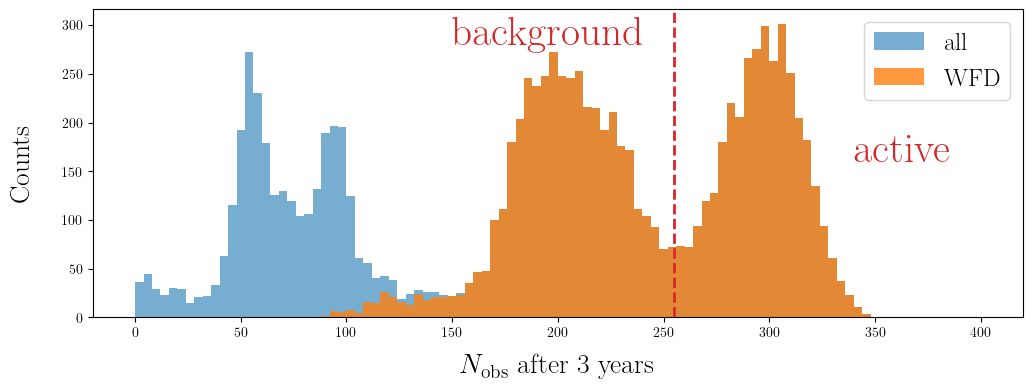

In [157]:
plt.figure(figsize=(12, 4))
plt.hist(Nobs_3, bins=100, alpha=0.6, range=(0, 400), label="all")
plt.hist(Nobs_3[Nobs_3_10 > 400], bins=100, alpha=0.8, range=(0, 400), color='C1', label="WFD")
plt.ylabel('Counts', fontsize=20, labelpad=20)
plt.xlabel(r'$N_{\rm obs}$ after 3 years', fontsize=20, labelpad=10)
plt.legend(fontsize=18)
plt.axvline(x=255, ls='--', color='C3', lw=2)
plt.text(150, 280, 'background', fontsize=30, color='C3')
plt.text(340, 160, 'active', fontsize=30, color='C3')

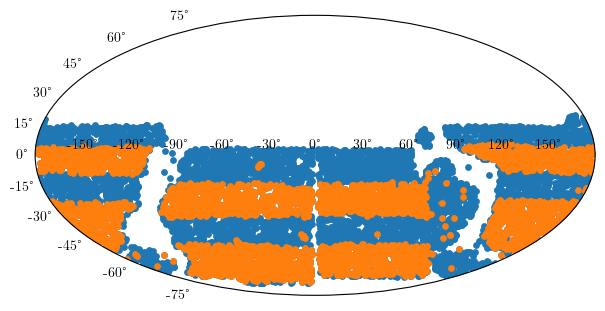

In [161]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(ra_3.radian[Nobs_3_10 > 400], dec_3.radian[Nobs_3_10 > 400], s=15, c='C0')
im1 = ax1.scatter(ra_3.radian[Nobs_3 > 255], dec_3.radian[Nobs_3 > 255], s=15, c='C1')


108918
DDF:
378
0.378


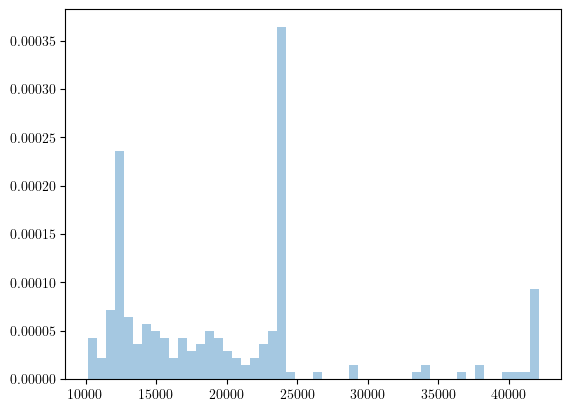

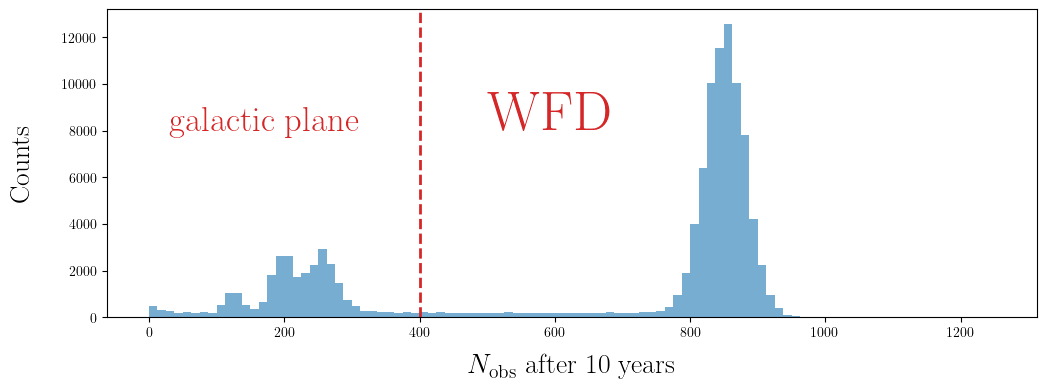

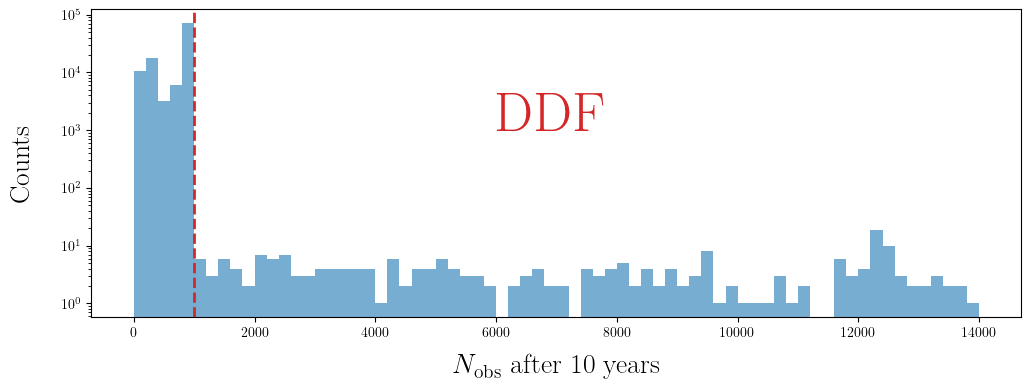

In [132]:
plt.figure()
plt.hist(Nobs_10[Nobs_10 > 10000], bins=50, alpha=0.4, density=True)

plt.figure(figsize=(12, 4))
plt.hist(Nobs_10, bins=100, alpha=0.6, range=(0, 1250))
plt.ylabel('Counts', fontsize=20, labelpad=20)
plt.xlabel(r'$N_{\rm obs}$ after 10 years', fontsize=20, labelpad=10)
plt.axvline(x=400, ls='--', color='C3', lw=2)
plt.text(500, 8000, 'WFD', fontsize=40, color='C3')
plt.text(30, 8000, 'galactic plane', fontsize=25, color='C3')
#plt.savefig("../Results/Figures/Nobs_threshold_WFD.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

plt.figure(figsize=(12, 4))
plt.hist(Nobs_10, bins=70, alpha=0.6, range=(0, 14000))
plt.ylabel('Counts', fontsize=20, labelpad=20)
plt.xlabel(r'$N_{\rm obs}$ after 10 years', fontsize=20, labelpad=10)
plt.axvline(x=1000, ls='--', color='C3', lw=2)
plt.text(6000, 1000, 'DDF', fontsize=40, color='C3')
plt.yscale('log')
#plt.savefig("../Results/Figures/Nobs_threshold_DDF.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

print(len(Nobs_10))
print("DDF:")
print(len(Nobs_10[Nobs_10 > 1000]))
print(378/100000 * 100)

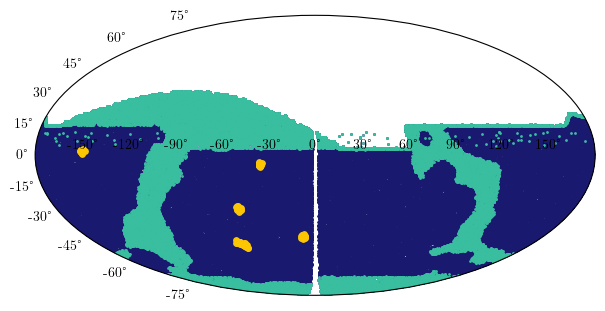

In [128]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(ra_10.radian, dec_10.radian, s=1, c='Midnightblue', label='WFD')
im1 = ax1.scatter(ra_10.radian[Nobs_10 > 1000], dec_10.radian[Nobs_10 > 1000], s=15, c='#fcc603', label='DDF')
im1 = ax1.scatter(ra_10.radian[Nobs_10 < 400], dec_10.radian[Nobs_10 < 400], s=1, c='#39bfa0', label='galactic plane')
#fig.colorbar(im1, ax=ax1, label="num observations", fraction=0.025)
# plt.legend(fontsize=20)

#plt.savefig("../Results/Figures/Nobs_sky1.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')


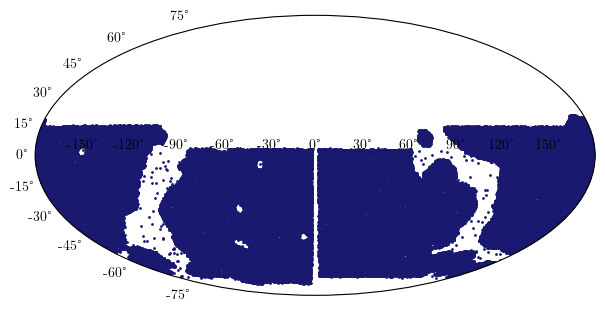

In [127]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(ra_10.radian[(Nobs_10 < 1000) & (Nobs_10 > 400)], 
                  dec_10.radian[(Nobs_10 < 1000) & (Nobs_10 > 400)], s=1, c='Midnightblue')
#plt.savefig("../Results/Figures/Nobs_sky2.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

# fig.colorbar(im1, ax=ax1, label="num observations", fraction=0.025)

In [53]:
open_cluster_c.transform_to(Galactic())

557

In [181]:
ra, dec = create_sky_pointings(100000)

MJD = 60768  # Yr 1.5
MJD = 61325  # Yr 3.
MJD = 65000
MJD = 61325 + 557  # Yr. 4.5
MJD_years = [60586, 60951, 61316, 61681, 62047, 62412, 62777, 63142, 63508, 63873]
ra_years, dec_years, Nobs_years = [], [], []

for y in MJD_years:
    test_ra, test_dec, test_Nobs, test_Nobs_10, test_gaps = get_Nobs_MJD(ra, dec, MJD=y)
    ra_years.append(test_ra)
    dec_years.append(test_dec)
    Nobs_years.append(test_Nobs)

check using ptree True
check using ptree True
check using ptree True
check using ptree True
check using ptree True
check using ptree True
check using ptree True
check using ptree True
check using ptree True
check using ptree True


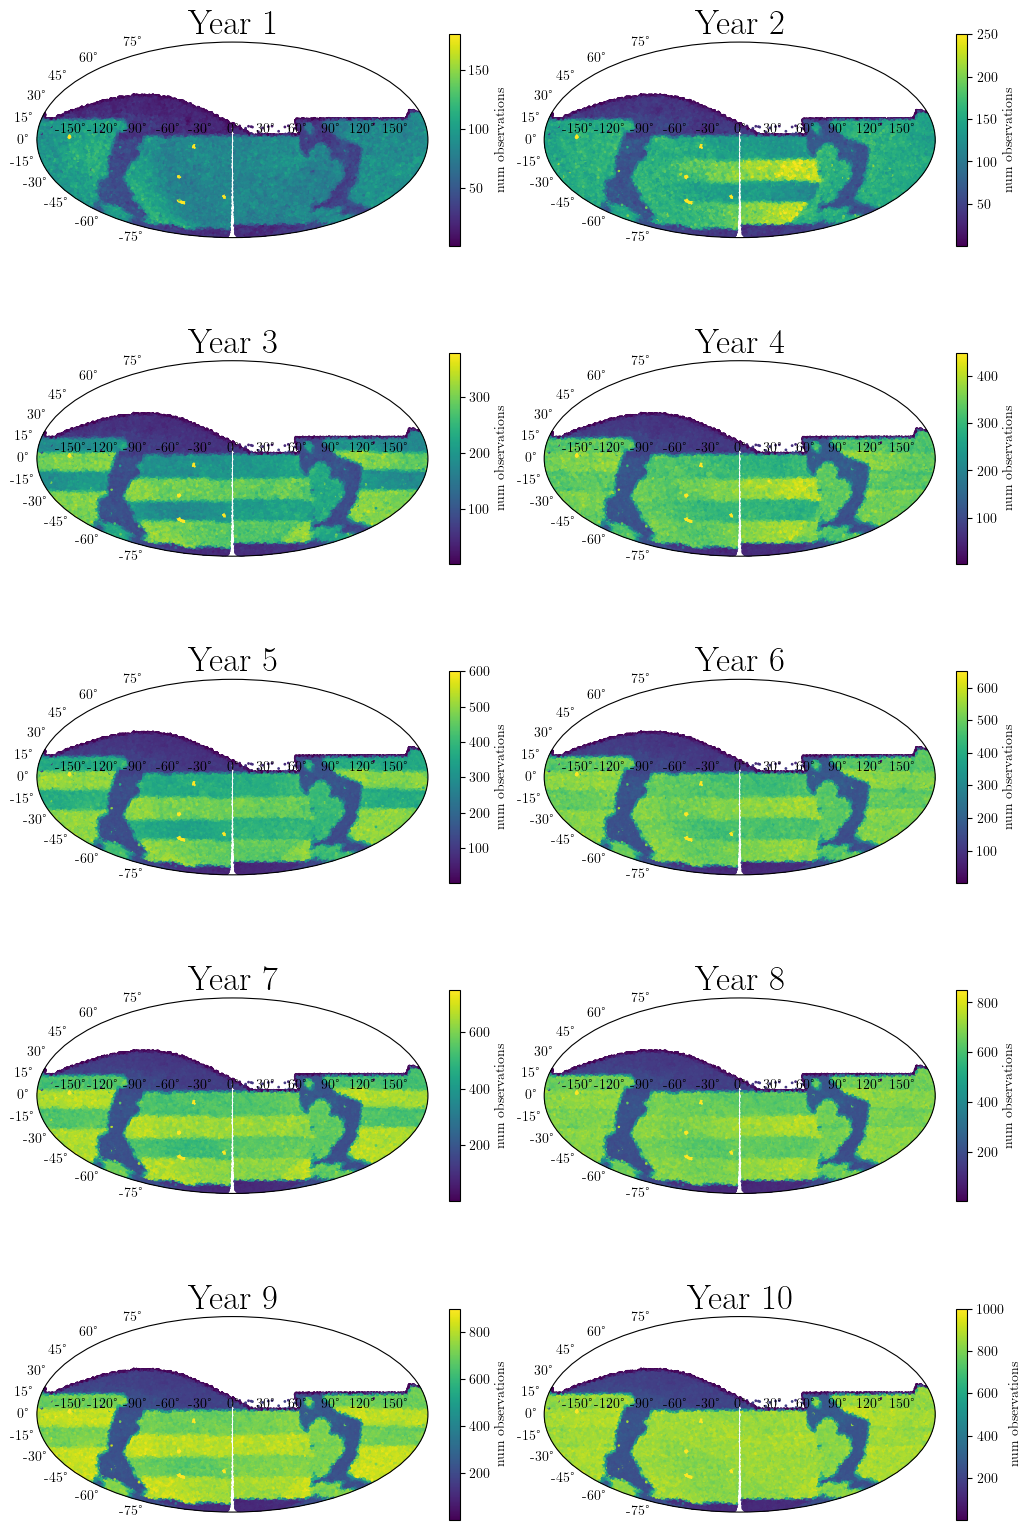

In [183]:
#test_Nobs[test_Nobs > 600] = 600
#test_Nobs[test_Nobs < 600] = 600

cutoff_years = [180, 250, 380, 450, 600, 650, 750, 850, 900, 1000]

fig = plt.figure(figsize=(12, 20))
for y in range(len(MJD_years)):
    Nobs_years[y][Nobs_years[y] > cutoff_years[y]] = cutoff_years[y]

    ax1 = fig.add_subplot(5,2,y+1, projection="mollweide")
    im1 = ax1.scatter((ra_years[y]).radian, (dec_years[y]).radian, s=1, c=Nobs_years[y])
    fig.colorbar(im1, ax=ax1, label="num observations", fraction=0.025)
    ax1.set_title("Year " + str(y+1), fontsize=25)
    
plt.savefig("../Results/Figures/Cadence_Nobs_uniformity_years_new.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')


In [ ]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(radians(test_ra), radians(test_dec), s=1, c=test_Nobs)
fig.colorbar(im1, ax=ax1, label="num observations", fraction=0.025)
ax1.set_title("Up to MJD " + str(MJD), fontsize=25)

(array([ 68.,  38., 100., 385., 242., 289., 277.,  67.,  39.,  34.,  42.,
         43.,  47., 119., 332., 578., 941., 937., 509., 235.,  87.,  12.,
          0.,   0.,   0.,  21.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
         360.,  380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,
         540.,  560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,
         720.,  740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,
         900.,  920.,  940.,  960.,  980., 1000.]),
 <BarContainer object of 50 artists>)

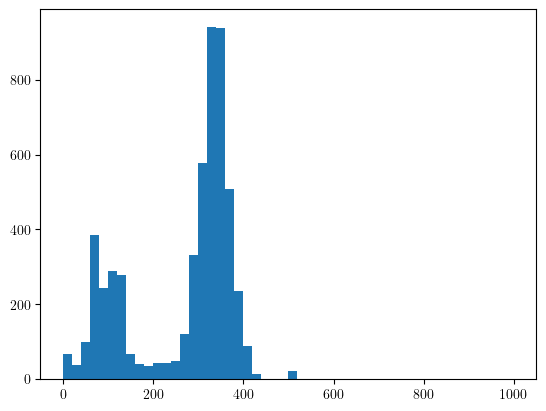

In [105]:
plt.hist(Nobs_years[3], bins=50, range=(0, 1000))

In [121]:
def get_Nobs(ra, dec, rolling):
    
    gen = synopsim.pointingsEnclosing(ra, dec, circRadius=0., pointingRadius=1.75, 
                                  usePointingTree=True)

    opsim_ra_list, opsim_dec_list, Nobs, gaps_list = [], [], [], []
    

    for p in range(len(ra)):

        obs = next(gen)
        obs = obs.sort_values(by=['expMJD'])

        opsim_ra = np.mean(obs['fieldRA'])
        opsim_dec = np.mean(obs['fieldDec'])
        opsim_mjd = obs['expMJD']

        if np.isnan(opsim_ra) or np.isnan(opsim_dec):
            continue
        
        if rolling:
            indices = (60768 < opsim_mjd) & (opsim_mjd < 61325)
        else:
            indices = opsim_mjd < 60768
            
        times = opsim_mjd[indices]
        gaps = np.diff(times)
        for g in gaps:
            gaps_list.append(g)
        
        if len(opsim_mjd[indices]) > 0.0:
            Nobs.append(len(opsim_mjd[indices]))
            opsim_ra_list.append(opsim_ra)
            opsim_dec_list.append(opsim_dec)
    
    gaps_list = np.array(gaps_list)
    Nobs = np.array(Nobs)
    opsim_ra_list = np.array(opsim_ra_list)
    opsim_dec_list = np.array(opsim_dec_list)
    opsim_ra_list -= 180
    
    return opsim_ra_list, opsim_dec_list, Nobs, gaps_list.flatten()

In [125]:
norol_ra, norol_dec, norol_Nobs, norol_gaps = get_Nobs(ra, dec, rolling=False)

check using ptree True


In [126]:
rol_ra, rol_dec, rol_Nobs, rol_gaps = get_Nobs(ra, dec, rolling=True)

check using ptree True


In [111]:
norol_Nobs[norol_Nobs > 200] = 200
rol_Nobs[rol_Nobs > 200] = 200

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(radians(norol_ra), radians(norol_dec), s=1, c=norol_Nobs)
fig.colorbar(im1, ax=ax1, label="num observations", fraction=0.025)
ax1.set_title("Year 0 - 1.5", fontsize=25)

ax2 = fig.add_subplot(222, projection="mollweide")
im2 = ax2.scatter(radians(rol_ra), radians(rol_dec), s=1, c=rol_Nobs)
fig.colorbar(im2, ax=ax2, label="num observations", fraction=0.025)
ax2.set_title("Year 1.5 - 3", fontsize=25)
fig.suptitle("Total number of observations", fontsize=25)
plt.savefig("N_observations_sky_v30.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()


NameError: name 'norol_Nobs' is not defined

Text(0.5, 1.0, 'Active footprint from Catarina')

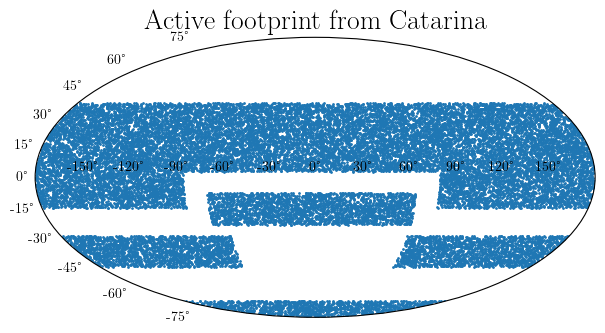

In [82]:
active = is_active(ra, dec)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221, projection="mollweide")
im1 = ax1.scatter(radians(ra2[active]), radians(dec[active]), s=1)
ax1.set_title("Active footprint from Catarina", fontsize=20)

# ask Lyn: when uniform? intermediate point?

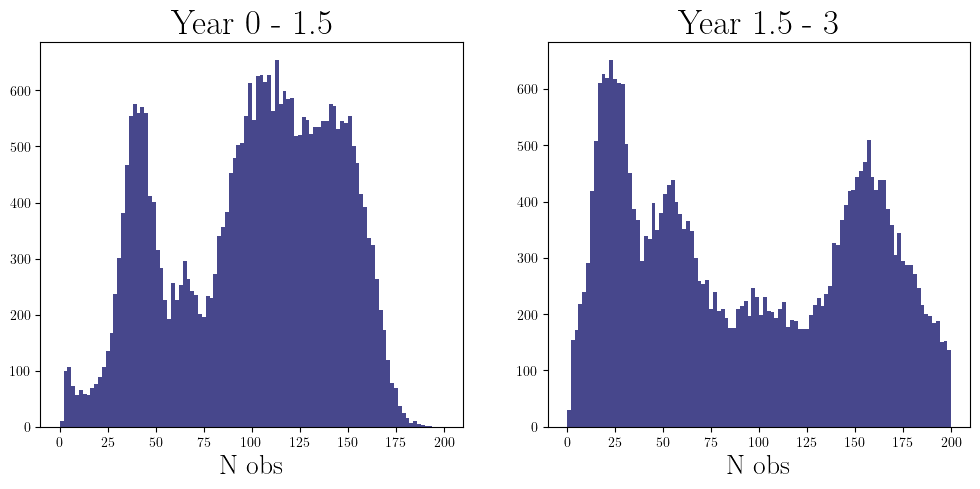

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(norol_Nobs[norol_Nobs < 200], bins=100, range=(0, 200), color='midnightblue', alpha=0.8)
ax[0].set_xlabel("N obs", fontsize=20)
ax[0].set_title("Year 0 - 1.5", fontsize=25)
ax[1].hist(rol_Nobs[rol_Nobs < 200], bins=100, range=(0, 200), color='midnightblue', alpha=0.8)
ax[1].set_xlabel("N obs", fontsize=20)
ax[1].set_title("Year 1.5 - 3", fontsize=25)
plt.show()

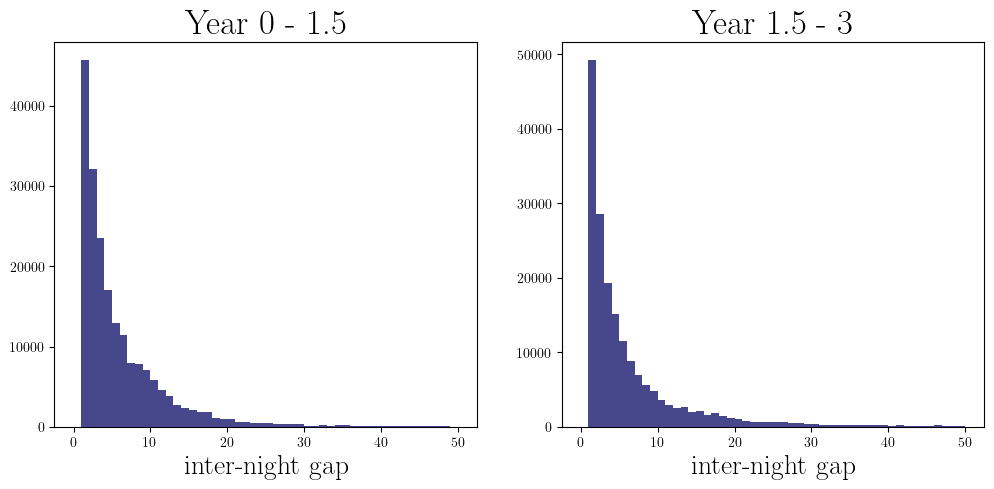

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(norol_gaps[norol_gaps >= 1], bins=50, color='midnightblue', alpha=0.8, range=(0, 50))
ax[0].set_xlabel("inter-night gap", fontsize=20)
ax[0].set_title("Year 0 - 1.5", fontsize=25)
ax[1].hist(rol_gaps[rol_gaps >= 1], bins=50, color='midnightblue', alpha=0.8, range=(0, 50))
ax[1].set_xlabel("inter-night gap", fontsize=20)
ax[1].set_title("Year 1.5 - 3", fontsize=25)
plt.show()

In [132]:
print("Mean inter-night gap non-rolling  : ", np.mean(norol_gaps[norol_gaps >= 1]))
print("Median inter-night gap non-rolling: ", np.median(norol_gaps[norol_gaps >= 1]))
print(" ")
print("Mean inter-night gap rolling  : ", np.mean(rol_gaps[rol_gaps >= 1]))
print("Median inter-night gap rolling: ", np.median(rol_gaps[rol_gaps >= 1]))

Mean inter-night gap non-rolling  :  11.529019678717038
Median inter-night gap non-rolling:  4.0223338604628225
 
Mean inter-night gap rolling  :  11.516872512132355
Median inter-night gap rolling:  3.982557277959131


In [130]:
next(gen)

check using ptree True


,fieldRA,fieldDec,expMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,airmass,...,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id,_ra,_dec,intindex
obsHistID,,,,,,,,,,,,,,,,,,,,,


In [252]:
test = next(gen)

In [7]:
print(test.keys())

Index(['fieldRA', 'fieldDec', 'expMJD', 'flush_by_mjd', 'visitExposureTime',
       'filter', 'rotSkyPos', 'rotSkyPos_desired', 'numExposures', 'airmass',
       'seeingFwhm500', 'FWHMeff', 'seeingFwhmGeom', 'filtSkyBrightness',
       'night', 'slewTime', 'visitTime', 'slewDistance', 'fiveSigmaDepth',
       'altitude', 'azimuth', 'paraAngle', 'cloud', 'moonAlt', 'sunAlt',
       'note', 'fieldId', 'proposalId', 'block_id', 'observationStartLST',
       'rotTelPos', 'rotTelPos_backup', 'moonAz', 'sunAz', 'sunRA', 'sunDec',
       'moonRA', 'moonDec', 'moonDistance', 'solarElong', 'moonPhase',
       'cummTelAz', 'scripted_id', '_ra', '_dec', 'intindex'],
      dtype='object')


In [253]:
obs = 3

# sky_brightness = test.iloc[obs]['filtSkyBrightness']
lim_mag = test.iloc[obs]['fiveSigmaDepth']
band = test.iloc[obs]['filter']
zero_point = zeropoint(band)
lim_flux = flux(lim_mag, zero_point)
flux_error = lim_flux / 5
  
# flux = ... (from model, zp = zero_point)
# new_flux = np.random.normal(loc=flux, scale=abs(flux_error))
# mag_error = abs(-2.5 * flux_skynoise / (new_flux_ps * np.log(10)))

print("lim_mag = ", lim_mag)
print("band = ", band)
print("zero_point = ", zero_point)
print("lim_flux = ", lim_flux)

# Quantities to save per observation: expMJD, filter, seeingFwhmGeom, fiveSigmaDepth, filtSkyBrightness (for images), 

lim_mag =  21.846103012408726
band =  y
zero_point =  26.58
lim_flux =  78.26341513560334


In [179]:
print(type(gen))

<class 'generator'>


## Funtions for pipeline

In [17]:
def create_sky_pointings(N, dec_low=-90, dec_high=40):
    """
    Creates random points on a sphere (with limited declination).
    Acception fraction of points is around 2/3, so sample ~1.6 times as many points.
    """
    
    sample_number = int(N * 1.6)
    print(sample_number)
    ra_points = np.random.uniform(low=0, high=360, size=sample_number)
    dec_points = np.arcsin(2 * np.random.uniform(size=sample_number) - 1) / np.pi * 180

    dec_selection = (dec_points > dec_low) & (dec_points < dec_high)
    ra_points = ra_points[dec_selection]
    dec_points = dec_points[dec_selection]

    return ra_points, dec_points

In [16]:
def initialise_opsim_summary(ra_pointings, dec_pointings):
    myopsimv3 = '../data/OpSim_databases/draft2_rw0.9_uz_v2.99_10yrs.db'
    
    #synopsim = SynOpSim.fromOpSimDB(myopsimv3, opsimversion='fbsv2', usePointingTree=True, use_proposal_table=False,
    #                           subset='unique_all')
    
    gen = synopsim.pointingsEnclosing(ra_pointings, dec_pointings, circRadius=0., pointingRadius=1.75, 
                                  usePointingTree=True)
    return gen

In [15]:
def opsim_observation(gen):
    
    while True:
    
        obs = next(gen)
        opsim_ra = np.mean(obs['fieldRA'])
        opsim_dec = np.mean(obs['fieldDec'])

        print(opsim_ra, opsim_dec)

        if np.isnan(opsim_ra) or np.isnan(opsim_dec):
            print("Not accepted")
            continue
                
        print("Accepted!")
        obs = obs.sort_values(by=['expMJD'])
        
        opsim_times = obs['expMJD']
        opsim_filters = obs['filter']
        opsim_psf = obs['seeingFwhmGeom']
        opsim_lim_mag = obs['fiveSigmaDepth']
        opsim_sky_brightness = obs['filtSkyBrightness']
        break

    print(" ")
    return opsim_ra, opsim_dec, opsim_times, opsim_filters, opsim_psf, opsim_lim_mag, opsim_sky_brightness
   

In [14]:
def select_operation_years(times, filters, psf, lim_mag, sky_brightness, mjd_cutoff=61325):
    
    indices = times < mjd_cutoff
    
    return times[indices], filters[indices], psf[indices], lim_mag[indices], sky_brightness[indices]
    

In [277]:
ra_pointings, dec_pointings = create_sky_pointings(N=3000)
gen = generate_opsim_summary(ra_pointings, dec_pointings)
print(len(ra_pointings))
print(dec_pointings)

4800
3917
[ 2.75568767 29.2794942   6.99086864 ... 29.60173591 -7.71858702
 16.03629247]


In [296]:
ra, dec, times, filters, psf, lim_mag, sky_brightness = opsim_observation(gen)

308.22139063340677 -57.38261722493047
Accepted!
 


In [297]:
print(len(times), len(filters), len(lim_mag))
print(times)

844 844 844
obsHistID
198        60218.096924
248        60218.120480
1221       60219.190265
1271       60219.212663
1834       60220.067074
               ...     
2070189    63838.194623
2071871    63840.101626
2073366    63842.146628
2076064    63851.136539
2076114    63851.160713
Name: expMJD, Length: 844, dtype: float64


In [299]:
times, filters, psf, lim_mag, sky_brightness = select_operation_years(times, filters, psf, lim_mag, sky_brightness)
print(len(times), len(filters), len(lim_mag))
print(times)

270 270 270
obsHistID
198       60218.096924
248       60218.120480
1221      60219.190265
1271      60219.212663
1834      60220.067074
              ...     
610336    61296.094547
610386    61296.118128
618639    61308.113315
619635    61309.180755
619685    61309.204901
Name: expMJD, Length: 270, dtype: float64


In [301]:
print(type(times))

<class 'pandas.core.series.Series'>


In [303]:
times2 = np.array(times)
print(type(times2))

<class 'numpy.ndarray'>


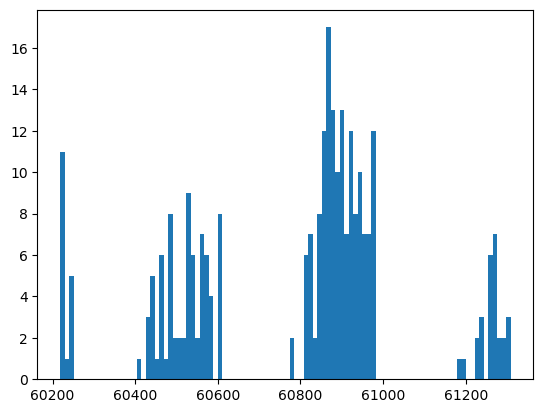

In [300]:
plt.hist(times, bins=100)
plt.show()

In [ ]:
days = test['expMJD']
filters = test['filter']
ra = test['_ra']
print((days[days < 61325]))
print(filters[days < 61325])

In [ ]:
print(ra / np.pi * 180)

In [ ]:
print(len(np.floor(days)))

In [ ]:
print(len(np.unique(np.floor(days))))

## With proposal table

In [9]:
myopsimv3 = '../data/OpSim_databases/baseline_v3.0_10yrs.db'

In [11]:
synopsim = SynOpSim.fromOpSimDB(myopsimv3, opsimversion='fbsv2', usePointingTree=True, use_proposal_table=False,
                               subset='unique_all')

 reading from database sqlite:///../data/OpSim_databases/baseline_v3.0_10yrs.db
We have filterNull set to False
checking that summary table read in

Reading in raw tables successful
replacing names works
dropping duplicates works
dithered column names exists 
Changing units for fbsv2 from degrees


In [12]:
gen = synopsim.pointingsEnclosing(ra_points, dec_points, circRadius=0., pointingRadius=1.75, 
                                  usePointingTree=True)

In [20]:
test = next(gen)

In [22]:
(test['proposalId'])

obsHistID
722115     61
1947104     2
459944     23
722065     11
459923      2
           ..
1772331    81
314502     48
1906708     9
26573      12
26596      35
Name: proposalId, Length: 908, dtype: int64

In [17]:
test['expMJD']

obsHistID
291291     60726.182094
291341     60726.207192
1309230    62527.342294
1309252    62527.353764
367166     60885.964558
               ...     
98207      60368.275364
1519738    62885.321100
446940     61014.333456
1519688    62885.296197
976111     61893.135333
Name: expMJD, Length: 901, dtype: float64

In [144]:
def get_Nobs_band(ra, dec, rolling, band):
    
    gen = synopsim.pointingsEnclosing(ra, dec, circRadius=0., pointingRadius=1.75, 
                                  usePointingTree=True)

    opsim_ra_list, opsim_dec_list, Nobs, gaps_list = [], [], [], []
    

    for p in range(len(ra)):

        obs = next(gen)
        obs = obs.sort_values(by=['expMJD'])

        opsim_ra = np.mean(obs['fieldRA'])
        opsim_dec = np.mean(obs['fieldDec'])
        opsim_mjd = obs['expMJD']
        opsim_band = obs['filter']

        if np.isnan(opsim_ra) or np.isnan(opsim_dec):
            continue
        
        if rolling:
            indices = (60768 < opsim_mjd) & (opsim_mjd < 61325) & (opsim_band == band)
        else:
            indices = opsim_mjd < 60768 
            indices2 = opsim_band == band
            
        times = opsim_mjd[indices][indices2]
        gaps = np.diff(times)
        for g in gaps:
            gaps_list.append(g)
        
        if len(opsim_mjd[indices][indices2]) > 0.0:
            Nobs.append(len(opsim_mjd[indices][indices2]))
            opsim_ra_list.append(opsim_ra)
            opsim_dec_list.append(opsim_dec)
    
    gaps_list = np.array(gaps_list)
    Nobs = np.array(Nobs)
    opsim_ra_list = np.array(opsim_ra_list)
    opsim_dec_list = np.array(opsim_dec_list)
    opsim_ra_list -= 180
    
    return opsim_ra_list, opsim_dec_list, Nobs, gaps_list.flatten()

In [157]:
ra, dec = create_sky_pointings(5000)

r_ra, r_dec, r_Nobs, r_gaps = get_Nobs_band(ra, dec, rolling=False, band='r')
i_ra, i_dec, i_Nobs, i_gaps = get_Nobs_band(ra, dec, rolling=False, band='i')
z_ra, z_dec, z_Nobs, z_gaps = get_Nobs_band(ra, dec, rolling=False, band='z')
y_ra, y_dec, y_Nobs, y_gaps = get_Nobs_band(ra, dec, rolling=False, band='y')

check using ptree True
check using ptree True
check using ptree True
check using ptree True


6.00578183676771


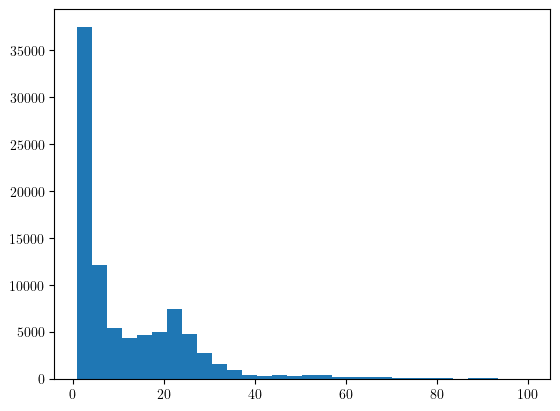

In [156]:
inds = (r_gaps > 0.9) & (r_gaps < 100)
plt.hist(r_gaps[inds], bins=30)
print(np.median(r_gaps[inds]))

7.8224921059591


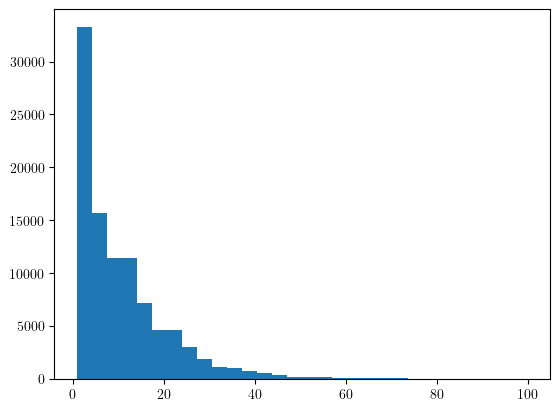

In [155]:
inds = (i_gaps > 0.9) & (i_gaps < 100)
plt.hist(i_gaps[inds], bins=30)
print(np.median(i_gaps[inds]))


In [158]:
inds = (z_gaps > 0.9) & (z_gaps < 100)
print("z: ", np.median(z_gaps[inds]))

inds = (y_gaps > 0.9) & (y_gaps < 100)
print("y: ", np.median(y_gaps[inds]))

z:  8.928359354038548
y:  11.963431537027645


In [132]:
obs = next(gen)

In [136]:
obs['filter'].iloc[0] == 'r'

True

In [137]:
obs['filter'] == 'r'

obsHistID
1074999     True
239550     False
1074949    False
239500     False
447689     False
           ...  
1244633    False
32049      False
31999      False
1476572     True
1476622    False
Name: filter, Length: 185, dtype: bool